# *Polioudakis 2019 dataset:* Inferring neural progenitor states during indirect neurogenesis from single cell data - scFates

In [1]:
pwd

'/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/0.scRNA-seq_processing'

### **Loading modules and settings**

In [2]:
import sys
#!{sys.executable} -m pip -q install palantir fa2
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn 
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


### **Loading data with Seurat PCA coordinates and normalization**

In [3]:
# JM
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/pol19_counts.h5ad")

milestones = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_output/polioudakis19_scFates_clustering.tsv", sep='\t', index_col=0)

adata.obs = pd.concat([adata.obs, milestones], axis=1)

cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/integrated_polioudakis19_cellembeddings.tsv", sep='\t')
cellembeddings.iloc[:,0] = cellembeddings.iloc[:,0]*-1 #for consistent better geometry
cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for consistent better geometry
cellembeddings = cellembeddings[cellembeddings.index.str.contains("pol19")]
cellembeddings.index = pd.DataFrame(cellembeddings.index)[0].str.split("pol19_", expand=True)[1]
adata = adata[adata.obs.index.isin(cellembeddings.index),:].copy()
cellembeddings = cellembeddings[cellembeddings.index.isin(adata.obs.index)].copy()
cellembeddings = cellembeddings.reindex(adata.obs.index)

adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

In [4]:
adata.obs.drop(columns=['t'], inplace=True) #will give problems later on, remove now

In [5]:
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3')

filtered out 24601 genes that are detected in less than 50 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [6]:
adata=adata[:,adata.var.highly_variable]

#Renormalized after filtering
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# keep raw cont data before log transformation
adata.raw = adata.copy()
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)


<AxesSubplot: title={'center': 'EOMES'}, xlabel='PC1', ylabel='PC2'>

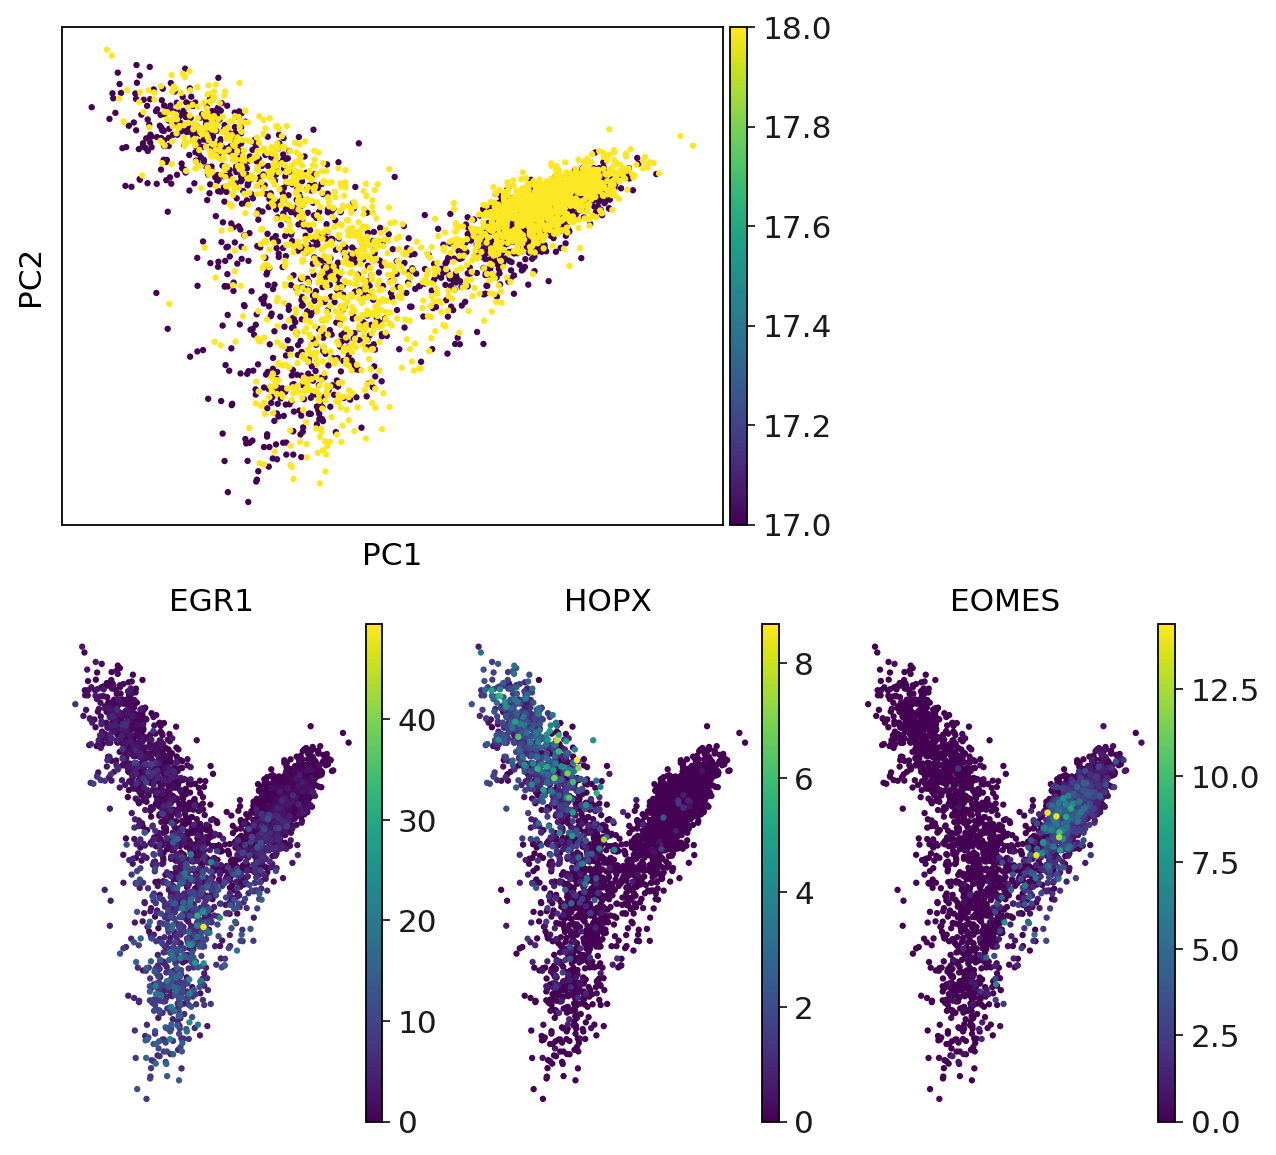

In [7]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(9,9),dpi_save=300)

fig=plt.figure()

gs=GridSpec(2,3) # 2 rows, 3 columns


ax1=fig.add_subplot(gs[0,0:2])
ax2=fig.add_subplot(gs[1,0]) 
ax3=fig.add_subplot(gs[1,1])
ax4=fig.add_subplot(gs[1,2])

sc.pl.pca(adata, color=["Gestation_week"], frameon=True, ax=ax1, show=False, title="")
sc.pl.pca(adata, color=["EGR1"], frameon=False, ax=ax2, show=False)
sc.pl.pca(adata, color=["HOPX"], frameon=False, ax=ax3, show=False)
sc.pl.pca(adata, color=["EOMES"], frameon=False, ax=ax4, show=False)


#fig.savefig('/home/jovyan/jm_jlab/data_indNeuro/tmp_figures/FigXt.pdf')

**Clustering form original publication**

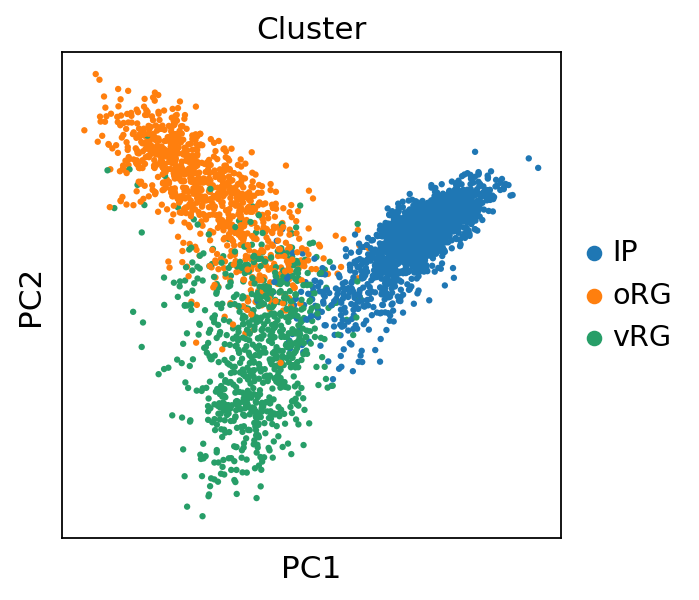

In [8]:
sc.set_figure_params(figsize=(4,4))

sc.pl.pca(adata, color=['Cluster'])

In [9]:
from pathlib import Path
Path("/home/jovyan/jm_jlab/data_indNeuro/tmp_figures/").mkdir(parents=True, exist_ok=True)

### **Computing force-directed graph**

In [10]:
sc.pp.neighbors(adata, n_pcs=2, n_neighbors=50, method='gauss') #Also necessary for later force-directed graph computation

computing neighbors
    using 'X_pca' with n_pcs = 2
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:17)


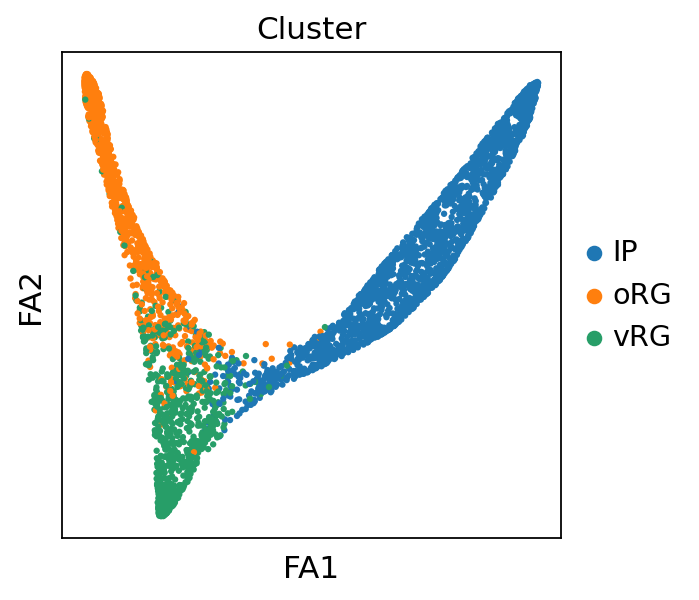

In [11]:
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]

sc.tl.draw_graph(adata,init_pos='X_pca2d')

sc.pl.draw_graph(adata, color='Cluster') #Polioudakis et al 2019 clustering

### **Run Palantir to obtain multiscale diffusion space**

In [12]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections.iloc[:,0:2])
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)
adata.obsm["X_palantir"]=ms_data.values

Determing nearest neighbor graph...
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Tree learning

## **Tree learning with EPG** - Exploration

## **Tree learning with EPG** - Selection

inferring a principal tree --> parameters used 
    50 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:53) --> added 
    .uns['epg'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


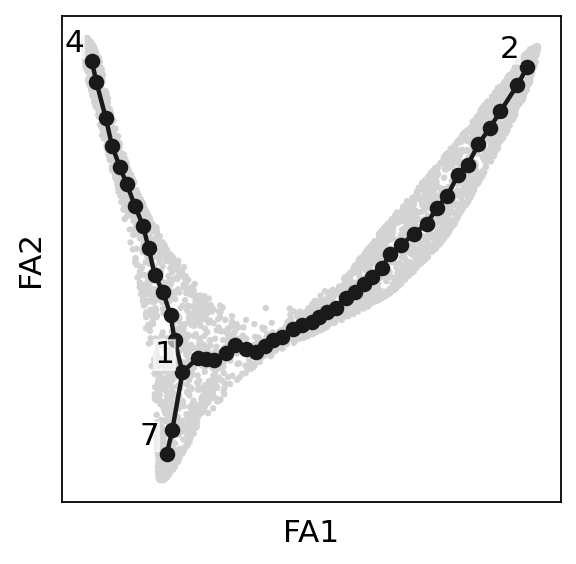

In [13]:
sc.set_figure_params(figsize=(4,4))

scf.tl.tree(adata,method="epg",Nodes=50,use_rep="palantir",
            device="cpu",seed=1)
scf.pl.graph(adata)

#### Projecting into PCA dim red

In [14]:
adata

AnnData object with n_obs × n_vars = 3667 × 4000
    obs: 'orig.ident', 'Cluster', 'Subcluster', 'Donor', 'Layer', 'Gestation_week', 'Library', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 'n_counts_all'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Cluster_colors', 'neighbors', 'draw_graph', 'graph', 'epg'
    obsm: 'X_pca', 'X_pca2d', 'X_draw_graph_fa', 'X_palantir', 'X_R'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

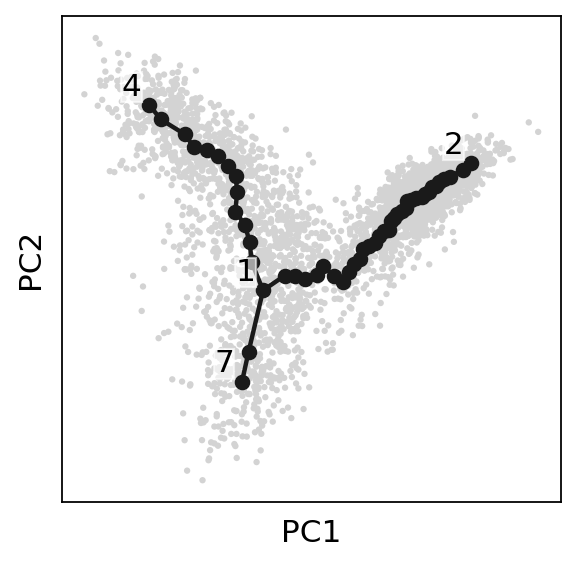

In [15]:
sc.set_figure_params(figsize=(4,4))

scf.pl.graph(adata, basis="pca")

### Selecting a root and computing pseudotime

Using FOS marker

In [16]:
adata

AnnData object with n_obs × n_vars = 3667 × 4000
    obs: 'orig.ident', 'Cluster', 'Subcluster', 'Donor', 'Layer', 'Gestation_week', 'Library', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'milestones', 'segmentation', 'n_counts_all'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Cluster_colors', 'neighbors', 'draw_graph', 'graph', 'epg'
    obsm: 'X_pca', 'X_pca2d', 'X_draw_graph_fa', 'X_palantir', 'X_R'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [17]:
adata.var_names[adata.var_names.isin(["FOS"])]

Index(['FOS'], dtype='object')

In [18]:
scf.tl.root(adata,"FOS")

scf.tl.convert_to_soft(adata,1,1000) #soft assignment

automatic root selection using FOS values
node 7 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [19]:
adata.obsm['X_R'].shape

(3667, 50)

In [20]:
adata.obsm['X_pca'].shape

(3667, 2)

In [21]:
adata.obsm['X_palantir'].shape

(3667, 3)

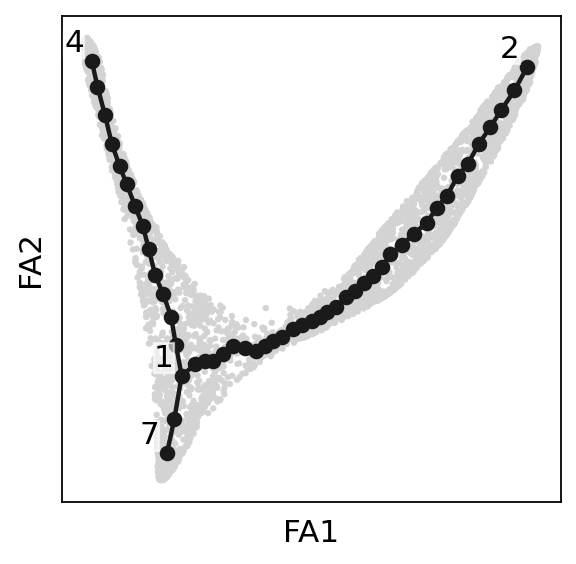

In [22]:
scf.pl.graph(adata)

In [23]:
scf.tl.pseudotime(adata, n_jobs=16, n_map=100, seed=42)

projecting cells onto the principal graph
    mappings:   0%|                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/

    mappings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]
    finished (0:00:47) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


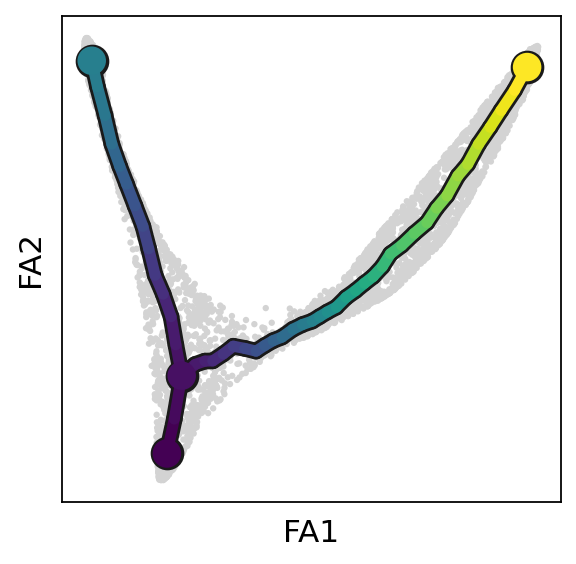

In [24]:
sc.set_figure_params(figsize=(4,4))

scf.pl.trajectory(adata)

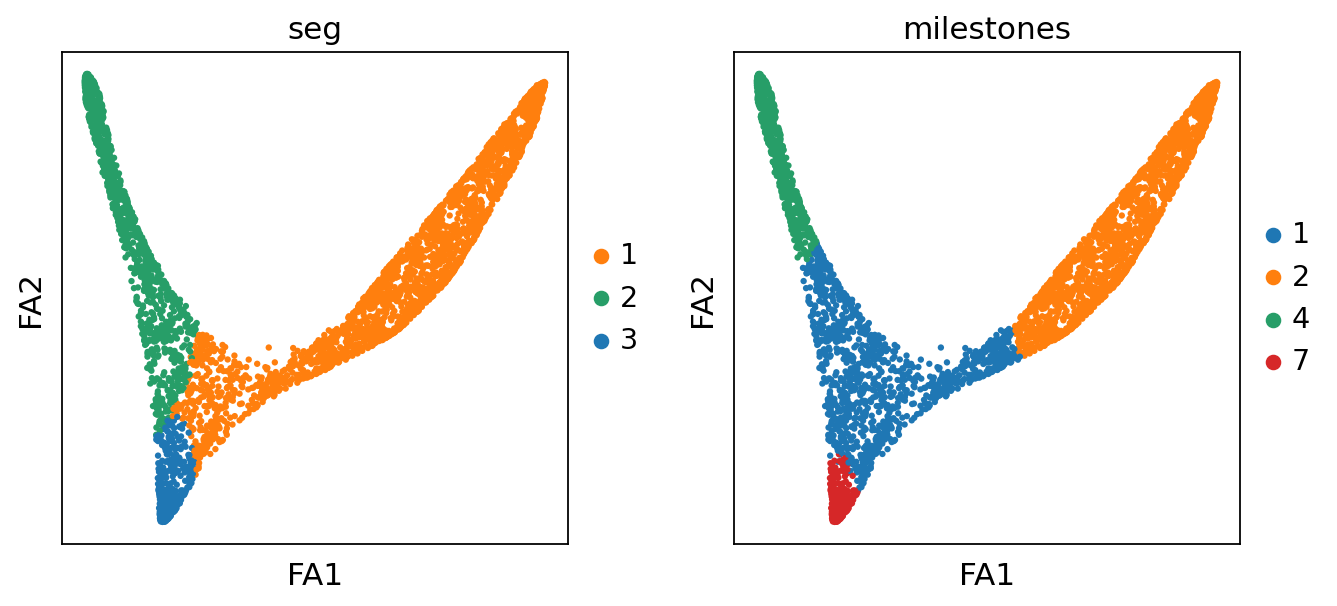

In [25]:
sc.set_figure_params(figsize=(4,4))

sc.pl.draw_graph(adata,color=["seg","milestones"]) 

In [26]:
scf.tl.rename_milestones(adata,["transient","IPC","oRG","vRG"])

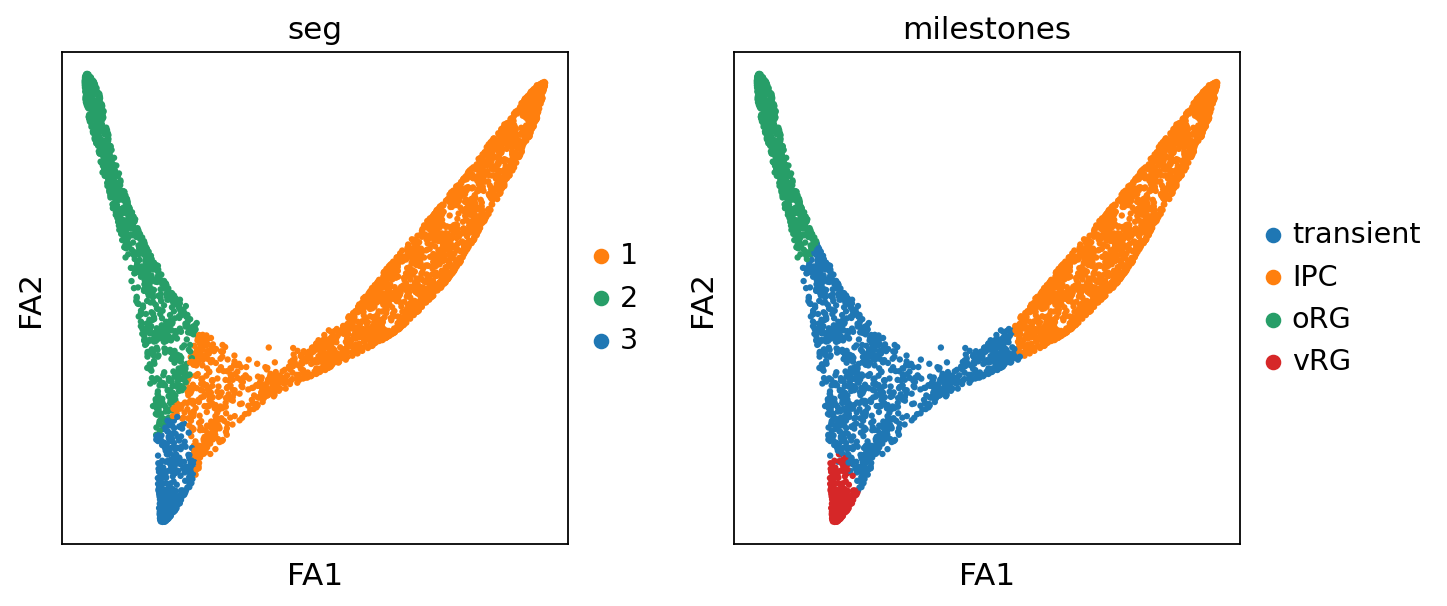

In [27]:
sc.set_figure_params(figsize=(4,4))

sc.pl.draw_graph(adata,color=["seg","milestones"])

**Highlight single-branch**

In [28]:
#Single branch
root_to_oRG=scf.tl.subset_tree(adata,root_milestone="vRG",milestones=["oRG"],copy=True)
#
root_to_IPC=scf.tl.subset_tree(adata,root_milestone="vRG",milestones=["IPC"],copy=True)

subsetting tree
node 3 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree extracted
--> added 
    .obs['old_milestones'], previous milestones from intial tree
subsetting tree
node 5 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.


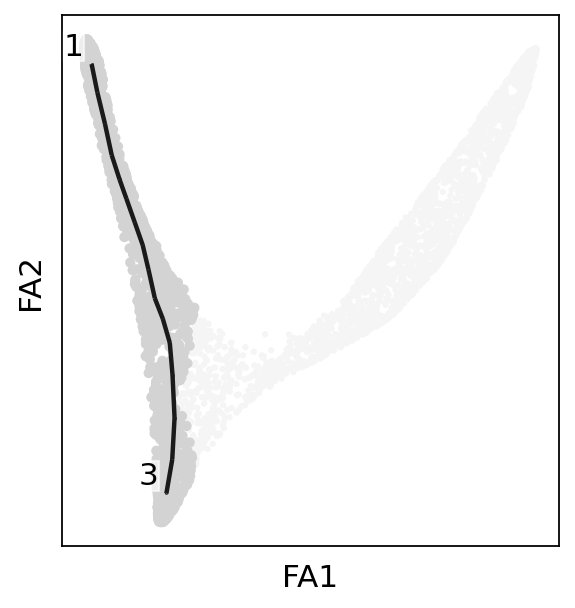

In [29]:
sc.set_figure_params(figsize=(4,4))

ax=sc.pl.scatter(adata,basis="draw_graph_fa",color="whitesmoke",show=False)
scf.pl.graph(root_to_oRG,basis="draw_graph_fa",size_nodes=.1,ax=ax)#, save="_tr21_oRGbranch.pdf")

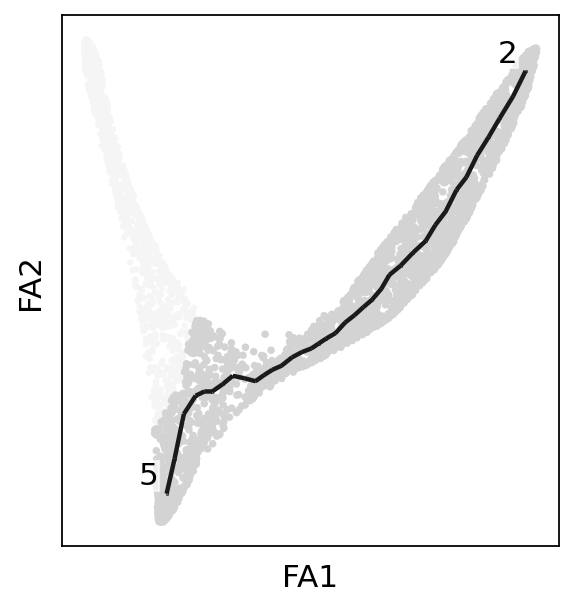

In [30]:
sc.set_figure_params(figsize=(4,4))

ax=sc.pl.scatter(adata,basis="draw_graph_fa",color="whitesmoke",show=False)
scf.pl.graph(root_to_IPC,basis="draw_graph_fa",size_nodes=.1,ax=ax)#, save="_tr21_IPCbranch.pdf")

<AxesSubplot: title={'center': 'milestones'}, xlabel='FA1', ylabel='FA2'>

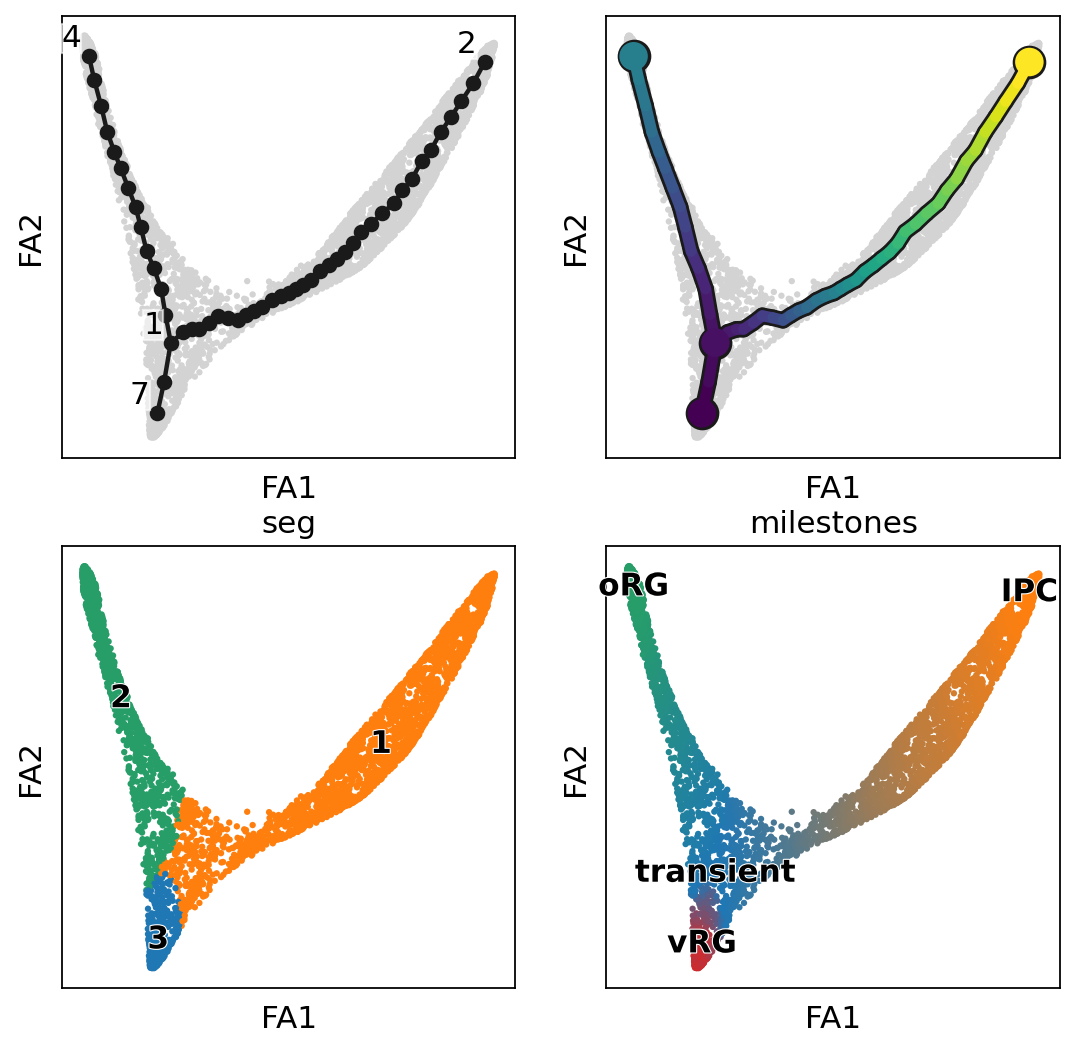

In [31]:
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(8,8))
axs=axs.ravel()
scf.pl.graph(adata,basis="draw_graph_fa",show=False,ax=axs[0])
scf.pl.trajectory(adata,basis="draw_graph_fa",show=False,ax=axs[1])
sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True)
scf.pl.milestones(adata,ax=axs[3],show=False,annotate=True)

### **Dendrogram representation**

Generating dendrogram of tree
    segment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]
    finished (0:00:02) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


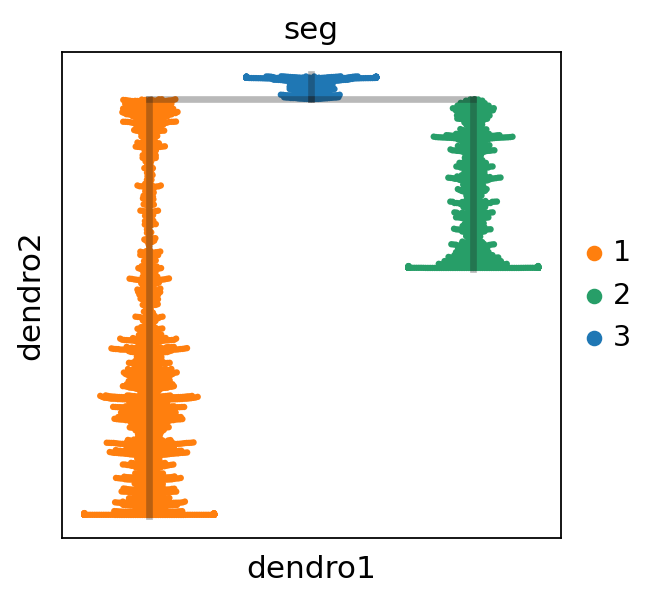

In [32]:
scf.tl.dendrogram(adata)

scf.pl.dendrogram(adata,color="seg")

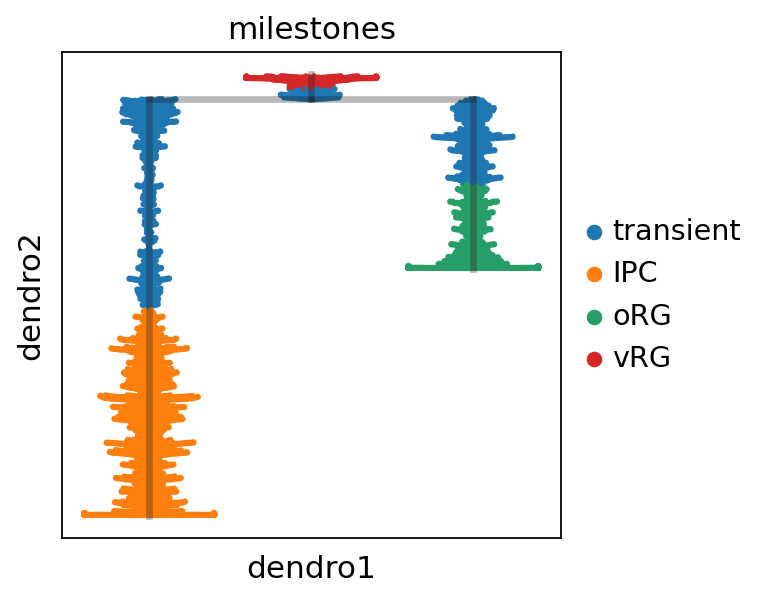

In [33]:
scf.pl.dendrogram(adata,color="milestones")

In [ ]:
pwd

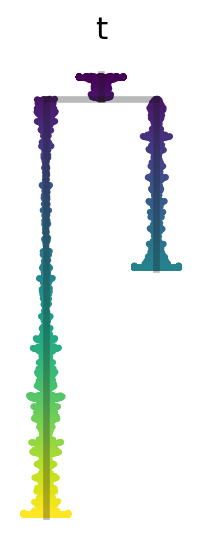

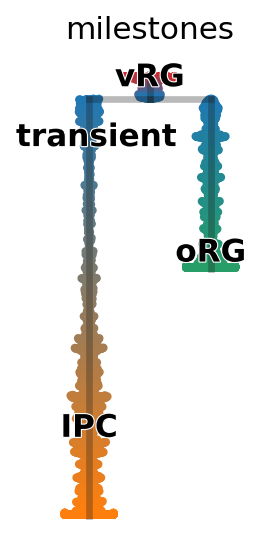

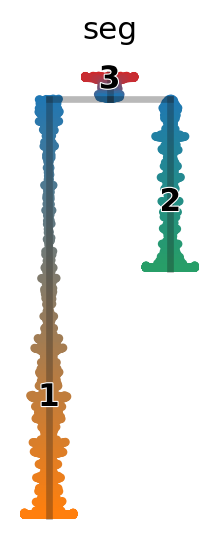

In [34]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,save="pol19_d1",cmap="viridis")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True,save="pol19_d2")
scf.pl.dendrogram(adata,color="seg",legend_loc="on data",color_milestones=True,legend_fontoutline=True,save="pol19_d3")

## Test and fit features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [35]:
scf.tl.test_association(adata,n_jobs=16, A_cut=0.5) #to compare same genes with Trevino 21, A_cut = 1 to high

test features for association with the trajectory
    single mapping : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:44<00:00, 38.15it/s]
    found 100 significant features (0:01:44) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


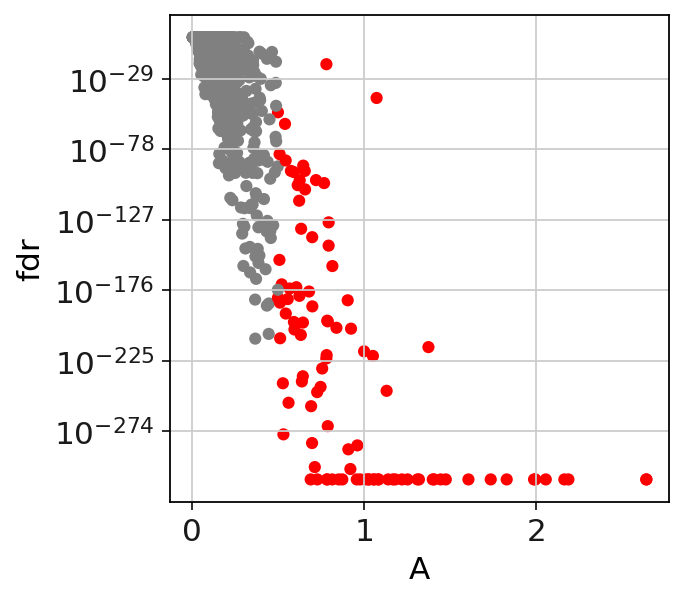

In [36]:
sc.set_figure_params()
scf.pl.test_association(adata)
#plt.savefig("figures/C.pdf",dpi=300)

In [37]:
adata.var[adata.var['signi'] == True].index #significantly genes n=179

Index(['VIM', 'TMSB10', 'GPM6B', 'NNAT', 'COL11A1', 'LIMCH1', 'KLF6', 'DCX',
       'MAP2', 'SLC1A3', 'MOXD1', 'RBFOX2', 'CST3', 'SFRP1', 'STMN2', 'PON2',
       'ITGB8', 'PTN', 'HSPB1', 'PTPRZ1', 'PPP1R17', 'CPE', 'CRYAB', 'CORO1C',
       'HMGCS1', 'SPARC', 'HES1', 'PRDX1', 'CNN3', 'STMN1', 'CTGF', 'GRIA2',
       'EGR1', 'CLU', 'SEPT7', 'TUBA1B', 'BAZ2B', 'SOX4', 'SOX9', 'C1orf61',
       'AKAP9', 'SAT1', 'AKAP12', 'BCAN', 'APC', 'NREP', 'TUBB2A', 'TUBB2B',
       'TMEM132B', 'TPM1', 'CYR61', 'CEP170', 'HES6', 'IQGAP2', 'CREB5',
       'NFIB', 'CARHSP1', 'DBI', 'SLA', 'FBXO32', 'NRG1', 'LRP8', 'IER2',
       'ELAVL4', 'PLPP3', 'PEA15', 'EOMES', 'FABP7', 'NEUROD6', 'FABP5', 'CKB',
       'CLMP', 'HSP90B1', 'TTYH1', 'FAM107A', 'CHD3', 'FOS', 'HOPX', 'NEUROD2',
       'ENC1', 'MLLT3', 'ID4', 'FGFBP3', 'SOX11', 'C8orf4', 'JUN', 'SSTR2',
       'SOX2', 'POU3F2', 'ROBO2', 'ZFP36L1', 'TCF4', 'HES5', 'HSPA1B',
       'HSPA1A', 'MT-RNR2', 'MLLT11', 'DDAH2', 'CD24', 'ENSG00000279576'],
      

In [38]:
scf.tl.fit(adata,n_jobs=16)

fit features associated with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.05it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:04) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


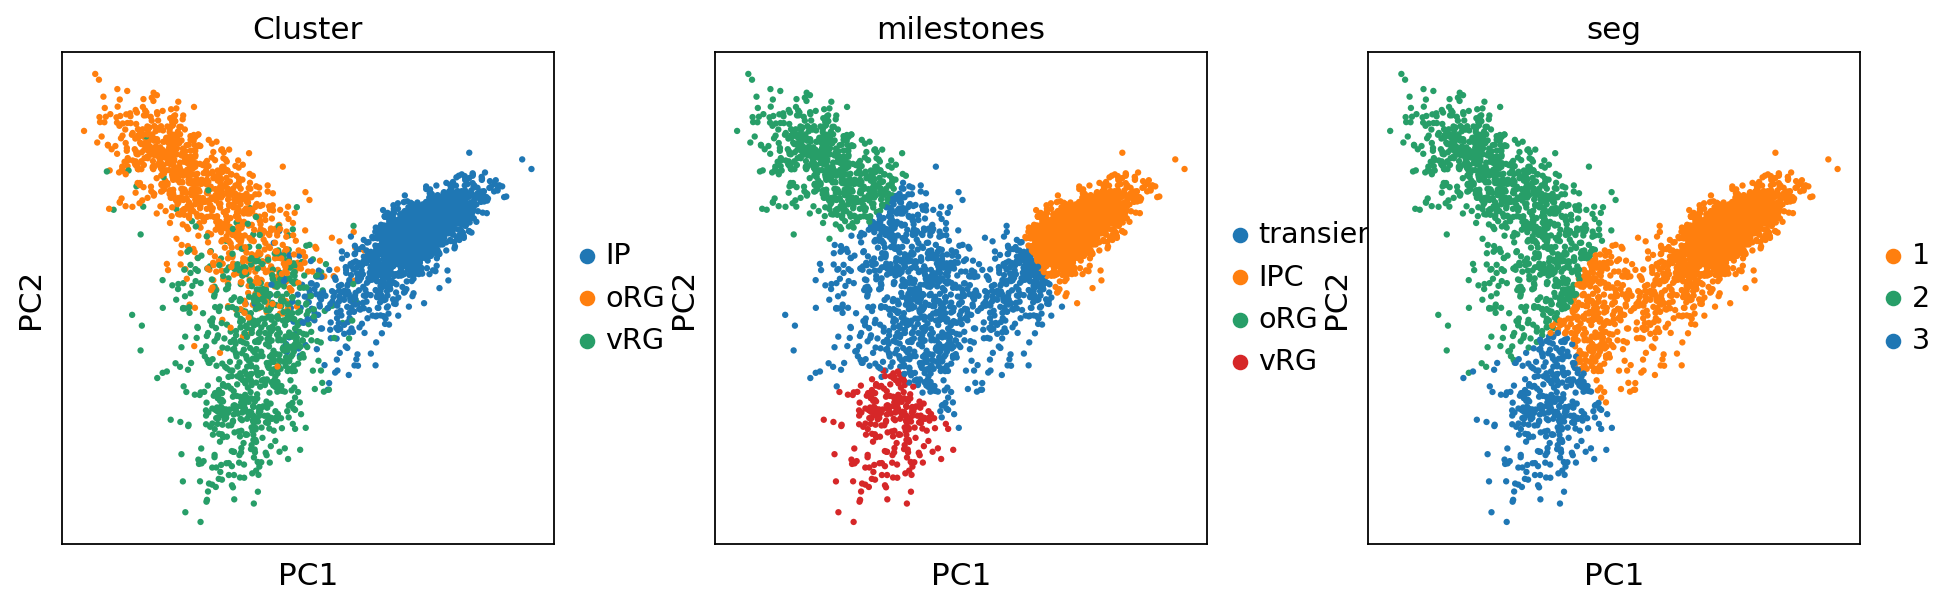

In [39]:
sc.pl.pca(adata, color = ['Cluster', 'milestones', 'seg'])

In [40]:
adata.obs['segmentation'] = np.select([adata.obs['seg'] == '1', adata.obs['seg'] == '3'],
                            ['s_IPC',  's_vRG'], 
                            default='s_oRG')

### **Saving for later analysis**

#### Plotting specific markers

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

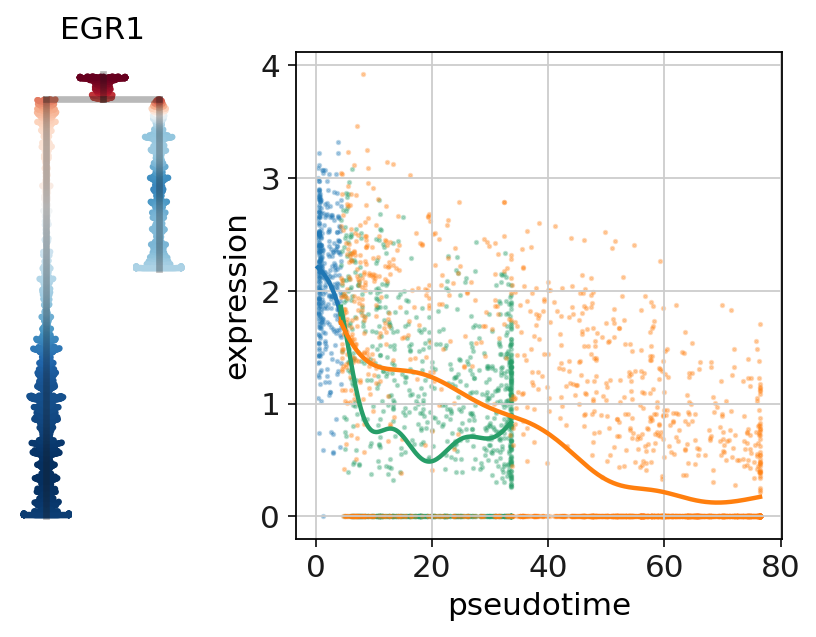

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

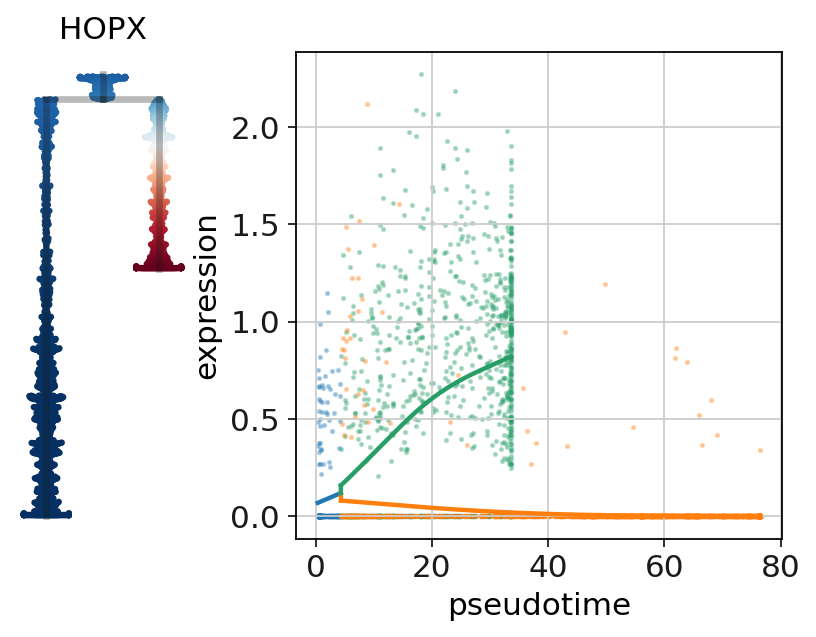

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

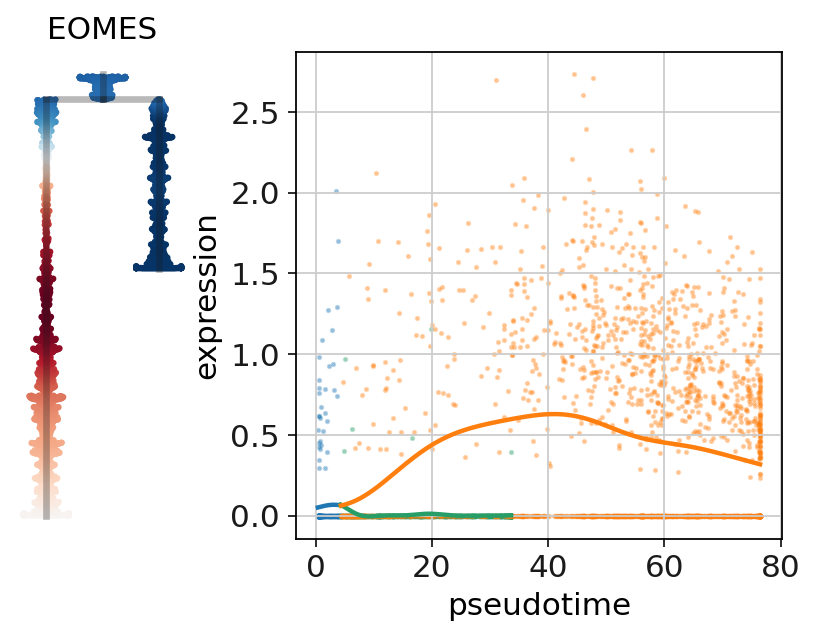

In [41]:
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"EGR1",basis="dendro",wspace=-.25)#,save="_E1.pdf")
scf.pl.single_trend(adata,"HOPX",basis="dendro",wspace=-.25)#,save="_E2.pdf")
scf.pl.single_trend(adata,"EOMES",basis="dendro",wspace=-.25)#,save="_E3.pdf")

## **Final plot**

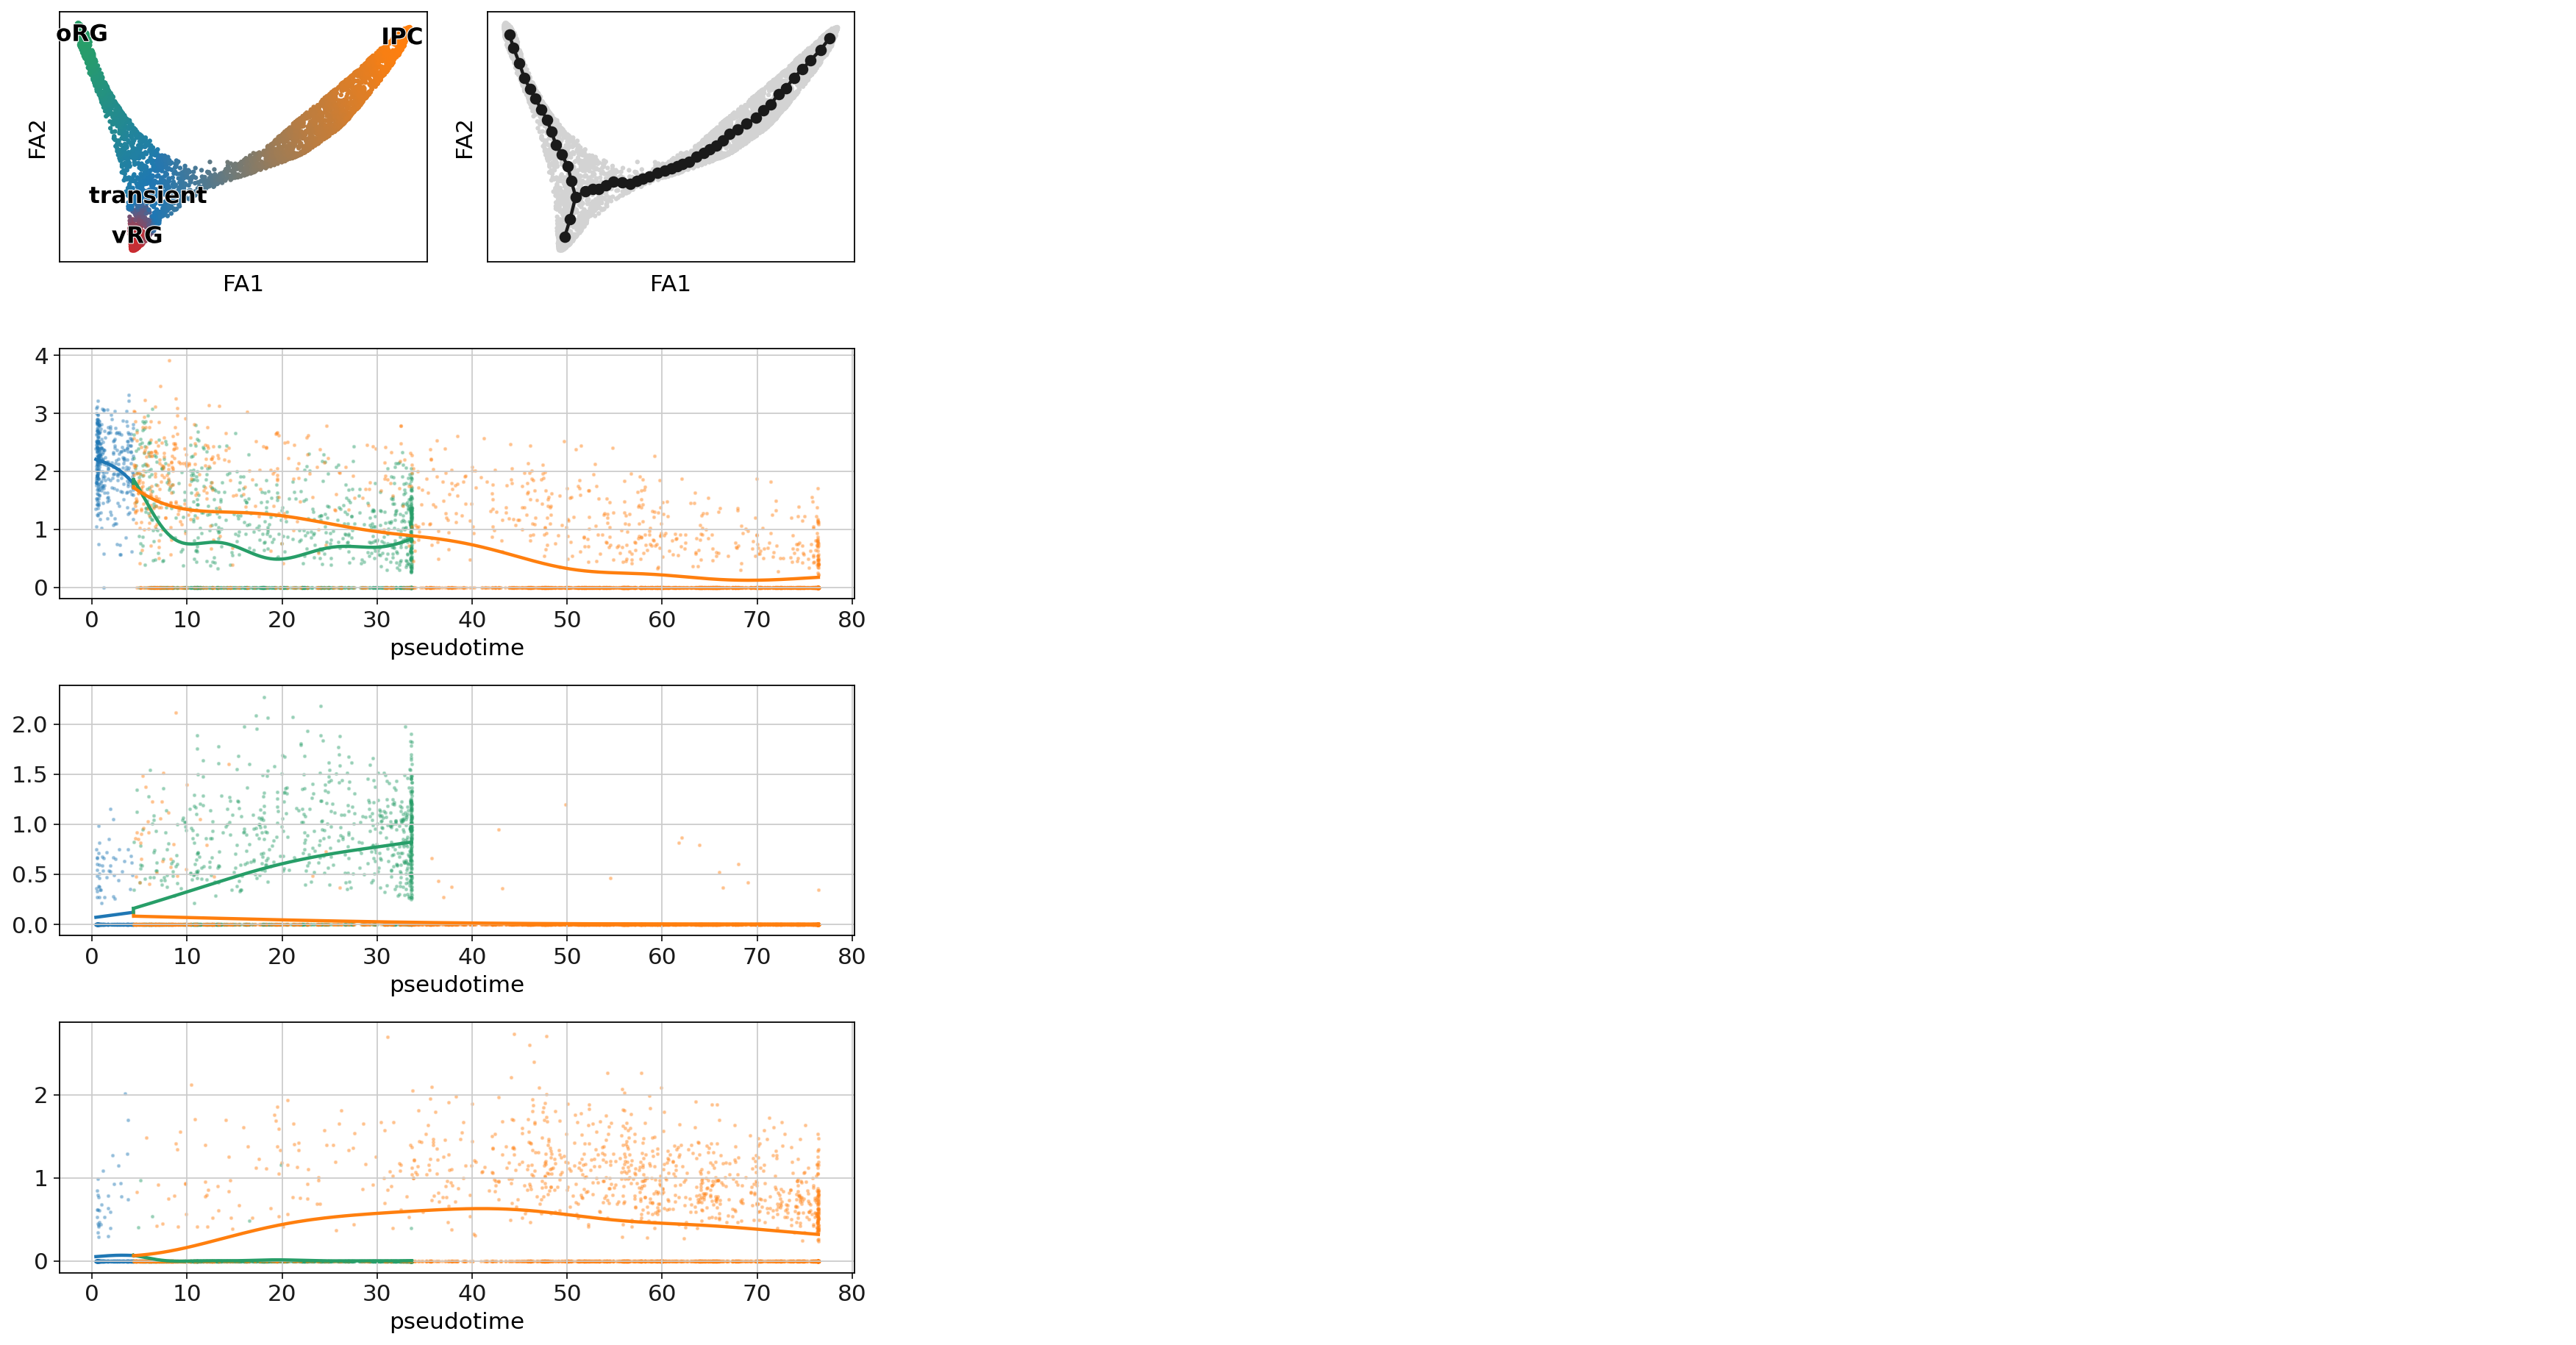

In [64]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(22, 14),dpi_save=300)

fig=plt.figure()

gs=GridSpec(5,6)


ax0=fig.add_subplot(gs[0,0:1])
ax1=fig.add_subplot(gs[1:2,0:2])
ax11=fig.add_subplot(gs[2:3,0:2])
ax111=fig.add_subplot(gs[3:4,0:2])

ax2=fig.add_subplot(gs[0,1:2])
ax3=fig.add_subplot(gs[3:4,0:1])
ax33=fig.add_subplot(gs[3:4,1:2])

ax20=fig.add_subplot(gs[0,2:3]) 
ax21=fig.add_subplot(gs[1,2:3]) 
ax22=fig.add_subplot(gs[2,2:3]) 

ax5=fig.add_subplot(gs[0,3:6])
#ax5.set_title('ax1 title')

ax6=fig.add_subplot(gs[1,3:6])
ax7=fig.add_subplot(gs[2,3:6])

# PCA plot

scf.pl.milestones(adata,show=False,ax=ax0,annotate=True, title="")

scf.pl.graph(adata,basis="draw_graph_fa", ax=ax2, forks=False, tips=False, show=False)

scf.pl.single_trend(adata,"EGR1",basis="dendro", ax_trend=ax1, wspace=-.25, ylab=None, title=False, plot_emb=False, show=False)
scf.pl.single_trend(adata,"HOPX",basis="dendro", ax_trend=ax11, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)
scf.pl.single_trend(adata,"EOMES",basis="dendro", ax_trend=ax111, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)


ax3.axis('off')
ax33.axis('off')
ax20.axis('off')
ax21.axis('off')
ax22.axis('off')
ax5.axis('off')
ax6.axis('off')
ax7.axis('off')

fig.tight_layout()

fig.savefig('/home/jovyan/jm_jlab/SF_1.pdf',dpi=300)